Filter and Merge Extracted Interactions
===

For Ruyuan Wan's survival analysis, which requires different conditions.

Builds on the three `Extraction` jupyter notebooks in this directory.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from datetime import timezone
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support')

In [4]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [5]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [6]:
working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
assert os.path.exists(working_dir)

### Load the site metadata

In [30]:
site_metadata_filepath = "/home/lana/shared/caringbridge/data/derived/site_metadata/site_metadata.feather"
site_df = pd.read_feather(site_metadata_filepath)
len(site_df)

840943

Filter by three conditions.

In [31]:
len(site_df[site_df.visits > 2])

654980

In [32]:
len(site_df[site_df.isSpam.isna()])

748405

In [33]:
len(site_df[(site_df.isDeleted.isna())|(site_df.isDeleted == '0')])

675234

In [34]:
subset_site_df = site_df[(site_df.visits > 2)&(site_df.isSpam.isna())&((site_df.isDeleted.isna())|(site_df.isDeleted == '0'))]
len(subset_site_df)

535984

In [35]:
valid_site_ids = set(subset_site_df.site_id)
len(valid_site_ids)

535984

### Define valid time range

In [18]:
start_date = datetime.fromisoformat('2014-01-01').replace(tzinfo=timezone.utc)
start_timestamp = int(start_date.timestamp()) * 1000
end_date = datetime.fromisoformat('2019-02-19').replace(tzinfo=timezone.utc)
end_timestamp = int(end_date.timestamp()) * 1000
start_timestamp, end_timestamp

(1388534400000, 1550534400000)

### Filter raw interactions files

Filters each interactions file to include only selected users.

We filter first to greatly reduce the size of the data when we subsequently merge.

In [14]:
source_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/csv_data"
gb_filepath = os.path.join(source_dir, "old_gb_metadata_raw.csv")
comments_filepath = os.path.join(source_dir, "new_comments_metadata_raw.csv")
amps_filepath = os.path.join(source_dir, "new_amps_metadata_raw.csv")

gb_filtered_filepath = os.path.join(working_dir, "old_gb_metadata_filtered.csv")
comments_filtered_filepath = os.path.join(working_dir, "new_comments_metadata_filtered.csv")
amps_filtered_filepath = os.path.join(working_dir, "new_amps_metadata_filtered.csv")

In [15]:
for input_filepath, output_filepath in [(comments_filepath, comments_filtered_filepath), 
                                        (amps_filepath, amps_filtered_filepath)]:
    skipped_for_invalid_site_count = 0
    skipped_for_invalid_time_count = 0
    with open(input_filepath, 'r') as infile:
        with open(output_filepath, 'w') as outfile:
            for line in tqdm(infile, desc=os.path.basename(input_filepath)):
                if line.strip() == "":
                    continue
                site_id = int(line.split(",")[1])
                try:
                    created_at = int(line.split(",")[-2])
                except:
                    continue
                if site_id in valid_site_ids:
                    if created_at >= start_timestamp and created_at <= end_timestamp:
                        outfile.write(line)
                    else:
                        skipped_for_invalid_time_count += 1
                else:
                    skipped_for_invalid_site_count += 1
            print(output_filepath)
            print(f"Invalid site: {skipped_for_invalid_site_count}")
            print(f"Invalid time: {skipped_for_invalid_time_count}")

print("Finished filtering files.")

new_comments_metadata_raw.csv: 31052715it [01:38, 314980.16it/s]
new_amps_metadata_raw.csv: 43469it [00:00, 434686.27it/s]

/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions/new_comments_metadata_filtered.csv
Invalid site: 668717
Invalid time: 413761


new_amps_metadata_raw.csv: 63314738it [02:52, 367275.98it/s]

/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions/new_amps_metadata_filtered.csv
Invalid site: 1120826
Invalid time: 25234692
Finished filtering files.


Pre- and post-filtering word counts:
```
   63314738 new_amps_metadata_raw.csv
   31052715 new_comments_metadata_raw.csv
   
   36959218 new_amps_metadata_filtered.csv
   29970237 new_comments_metadata_filtered.csv

```

In [16]:
# proportion of remaining lines for amps and comments respectively
36959218 / 63314738, 29970237 / 31052715

(0.5837379916189498, 0.9651406326306734)

### Read interactions data

In [17]:
comments_cols = ['user_id','site_id','int_type','journal_oid','created_at','updated_at']
amps_cols = ['user_id','site_id','journal_oid','journal_user_id','created_at','updated_at']

In [18]:
s = datetime.now()
comments_df = pd.read_csv(comments_filtered_filepath, header=None, names=comments_cols)
print(datetime.now() - s)
len(comments_df)

0:00:28.921994


29970237

In [19]:
s = datetime.now()
amps_df = pd.read_csv(amps_filtered_filepath, header=None, names=amps_cols)
print(datetime.now() - s)
len(amps_df)

0:00:32.089755


36959218

## Merge with journal data

In [20]:
amps_df['int_type'] = 'amps'

In [21]:
ints_df = pd.concat([comments_df, amps_df.drop(columns='journal_user_id')], sort=False)
ints_df.reset_index(drop=True, inplace=True)
len(ints_df)

66929455

In [22]:
assert len(ints_df) == len(amps_df) + len(comments_df)

In [23]:
ints_df.columns

Index(['user_id', 'site_id', 'int_type', 'journal_oid', 'created_at',
       'updated_at'],
      dtype='object')

In [24]:
ints_df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at
0,30129333,960159,comment,54a98e294db9219c2c5b688f,1420377990000,1420377990000
1,30129355,960155,comment,54a9920fac7ee9c67c1cda44,1420378155000,1420378155000
2,30129373,960159,comment,54a98e294db9219c2c5b688f,1420378420000,1420378420000
3,23112149,960155,comment,54a9920fac7ee9c67c1cda44,1420380812000,1420380812000
4,19857345,960159,comment,54a98e294db9219c2c5b688f,1420381422000,1420381422000


In [25]:
# load the journal metadata
# load the dataframe with the index
s = datetime.now()
journal_metadata_dir = "/home/srivbane/shared/caringbridge/data/derived/journal_metadata"
journal_metadata_filepath = os.path.join(journal_metadata_dir, "journal_metadata.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:31.959428


17893390

In [26]:
journal_df.head()

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True
3,1104461640000,51bdf3e56ca0048f4e00cece,0,1,1104461640000,1,3,True
4,1104807180000,51bdf3e56ca0048f4e00cecc,0,1,1104807180000,1,4,True


In [27]:
journal_df['int_type'] = 'journal'

In [28]:
journal_cols = ['user_id', 'site_id', 'int_type', 'created_at', 'updated_at', 'journal_oid', 'site_index', 'is_nontrivial']
merged_df = pd.concat([ints_df, journal_df[journal_cols]], sort=False)
assert len(merged_df) == len(ints_df) + len(journal_df)
len(merged_df)

84822845

In [29]:
merged_df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial
0,30129333,960159,comment,54a98e294db9219c2c5b688f,1420377990000,1420377990000,NaN,NaN
1,30129355,960155,comment,54a9920fac7ee9c67c1cda44,1420378155000,1420378155000,NaN,NaN
2,30129373,960159,comment,54a98e294db9219c2c5b688f,1420378420000,1420378420000,NaN,NaN
3,23112149,960155,comment,54a9920fac7ee9c67c1cda44,1420380812000,1420380812000,NaN,NaN
4,19857345,960159,comment,54a98e294db9219c2c5b688f,1420381422000,1420381422000,NaN,NaN


In [30]:
# construct a map of (user_id) -> set(site_id)
# captures all sites on which a user_id has authored at least a single journal update
author_site_map = defaultdict(set)
for user_id, site_id in tqdm(zip(journal_df.user_id, journal_df.site_id), total=len(journal_df)):
    author_site_map[user_id].add(site_id)

100%|██████████| 17893390/17893390 [00:16<00:00, 1096137.23it/s]


In [31]:
s = datetime.now()
merged_df = merged_df.assign(is_self_interaction=merged_df.apply(lambda row: row.site_id in author_site_map[row.user_id], axis=1))
print(datetime.now() - s)

0:58:24.567392


In [32]:
# quickly verify that journal OIDs are unique
assert len(journal_df) == len(set(journal_df.journal_oid))

In [33]:
journal_oid_index_map = {journal_oid: site_index
    for journal_oid, site_index in zip(journal_df.journal_oid, journal_df.site_index)
}

In [34]:
merged_df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
0,30129333,960159,comment,54a98e294db9219c2c5b688f,1420377990000,1420377990000,NaN,NaN,False
1,30129355,960155,comment,54a9920fac7ee9c67c1cda44,1420378155000,1420378155000,NaN,NaN,False
2,30129373,960159,comment,54a98e294db9219c2c5b688f,1420378420000,1420378420000,NaN,NaN,False
3,23112149,960155,comment,54a9920fac7ee9c67c1cda44,1420380812000,1420380812000,NaN,NaN,False
4,19857345,960159,comment,54a98e294db9219c2c5b688f,1420381422000,1420381422000,NaN,NaN,False


In [35]:
# add site_index info to all interactions with a journal_oid
s = datetime.now()
merged_df.loc[~pd.isnull(merged_df.journal_oid), 'site_index'] = merged_df.loc[~pd.isnull(merged_df.journal_oid), 'journal_oid'].map(lambda journal_oid: journal_oid_index_map[journal_oid] if journal_oid in journal_oid_index_map else -1)
print(datetime.now() - s)

0:01:21.382510


In [36]:
# only 229 journals are reference by a journal oid that we don't have in the journal data
ints_journal_oid_set = set(ints_df.journal_oid)
journals_journal_oid_set = set(journal_df.journal_oid)
len(ints_journal_oid_set - journals_journal_oid_set)

1428

In [37]:
len(merged_df[merged_df.site_index == -1])

3000

In [38]:
merged_df.reset_index(drop=True, inplace=True)

In [39]:
merged_df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
0,30129333,960159,comment,54a98e294db9219c2c5b688f,1420377990000,1420377990000,1,NaN,False
1,30129355,960155,comment,54a9920fac7ee9c67c1cda44,1420378155000,1420378155000,0,NaN,False
2,30129373,960159,comment,54a98e294db9219c2c5b688f,1420378420000,1420378420000,1,NaN,False
3,23112149,960155,comment,54a9920fac7ee9c67c1cda44,1420380812000,1420380812000,0,NaN,False
4,19857345,960159,comment,54a98e294db9219c2c5b688f,1420381422000,1420381422000,1,NaN,False


In [40]:
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "interaction_metadata.feather")
merged_df.to_feather(interaction_metadata_filepath)
print("Finished.")

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pyarrow/feather.py:83: FutureWarning: The SparseDataFrame class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  if isinstance(df, _pandas_api.pd.SparseDataFrame):


Finished.


In [41]:
s = datetime.now()
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "interaction_metadata.csv")
merged_df.to_csv(interaction_metadata_filepath, index=False)
print(f"{datetime.now() - s}")
print("Finished.")

0:05:52.632017
Finished.


In [7]:
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "interaction_metadata.feather")
merged_df =  pd.read_feather(interaction_metadata_filepath)
len(merged_df)

84822845

### Compute metrics and validate

In [8]:
# test site, that previously had omitted interactions
merged_df[merged_df.site_id == 1031356]

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
2455068,28109834,1031356,comment,556e79fb4db92143759c188d,1433364616000,1433364616000,0,None,False
37535627,30906241,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535628,16828218,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535629,16045296,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535630,13834678,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
82268213,30906954,1031356,journal,556e79fb4db92143759c188d,1433303547000,1433303547000,0,True,True


In [9]:
#compute number of amps, comments, and journals in the first 30 days on each site
days30_ms = 1000 * 60 * 60 * 24 * 30

In [10]:
df = merged_df
df.dtypes

user_id                 int64
site_id                 int64
int_type               object
journal_oid            object
created_at              int64
updated_at              int64
site_index              int64
is_nontrivial          object
is_self_interaction      bool
dtype: object

In [11]:
s = datetime.now()
df.sort_values(by=['site_id', 'created_at'], inplace=True)
print(f"{datetime.now() - s}")

0:01:56.073189


In [12]:
invalid_created_at = df.created_at <= 0
print(np.sum(invalid_created_at))
df.loc[invalid_created_at, 'created_at'] = df.loc[invalid_created_at, 'updated_at']
print(np.sum(df.created_at <= 0))

44
0


In [13]:
df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
66929455,1,1,journal,51bdf3e56ca0048f4e00ced4,1103856900000,1103856900000,0,True,True
66929456,1,1,journal,51bdf3e56ca0048f4e00ced2,1103943240000,1103943240000,1,True,True
66929457,1,1,journal,51bdf3e56ca0048f4e00ced0,1104288840000,1104288840000,2,True,True
66929458,1,1,journal,51bdf3e56ca0048f4e00cece,1104461640000,1104461640000,3,True,True
66929459,1,1,journal,51bdf3e56ca0048f4e00cecc,1104807180000,1104807180000,4,True,True


In [15]:
first_journal_df = df[(df.int_type=='journal')&(df.is_nontrivial == True)]
first_journal_df = first_journal_df.drop_duplicates(subset='site_id')
assert len(first_journal_df) == len(set(first_journal_df.site_id))

In [16]:
site_start_dict = {row.site_id: row.created_at 
                   for row in tqdm(first_journal_df.itertuples(), total=len(first_journal_df))}

100%|██████████| 605630/605630 [00:01<00:00, 406351.96it/s]


In [20]:
site_counts_list = []
curr_site_id = -1
site_start_timestamp = -1
skipped_site_count = 0
for row in tqdm(df.itertuples(), total=len(df)):
    site_id = row.site_id
    if site_id != curr_site_id:
        if curr_site_id != -1:
            if skip_site:
                skipped_site_count += 1
            else:
                assert max_observed_elapsed_time >= 0
                site_counts_list.append({
                    'site_id': curr_site_id,
                    'journal_count': journal_count,
                    'amps_count': amp_count,
                    'comment_count': comment_count,
                    'site_tenure': max_observed_elapsed_time
                })
        
        journal_count = 0
        amp_count = 0
        comment_count = 0
        max_observed_elapsed_time = -1
        skip_site = False
        
        curr_site_id = site_id
        if site_id not in site_start_dict:
            skip_site = True
            site_start_timestamp = 0
        else:
            site_start_timestamp = site_start_dict[site_id]
    elapsed_time = row.created_at - site_start_timestamp
    is_journal_int = row.int_type == 'journal'
    if is_journal_int and (row.created_at < start_timestamp or row.created_at > end_timestamp):
        # this site was created outside the analysis period! we only want to include sites created since 2014
        skip_site = True
    if skip_site:
        continue
    if is_journal_int and elapsed_time > max_observed_elapsed_time:
        max_observed_elapsed_time = elapsed_time
    if elapsed_time <= days30_ms:
        if is_journal_int:
            journal_count += 1
        elif not row.is_self_interaction:
            if row.int_type == 'amps':
                amp_count += 1
            elif row.int_type == 'comment':
                comment_count += 1
if not skip_site:
    site_counts_list.append({
        'site_id': curr_site_id,
        'journal_count': journal_count,
        'amps_count': amp_count,
        'comment_count': comment_count,
        'site_tenure': max_observed_elapsed_time
    })
len(site_counts_list), skipped_site_count

100%|██████████| 84822845/84822845 [04:11<00:00, 337308.01it/s]


(320063, 335123)

In [21]:
site_counts_df = pd.DataFrame(site_counts_list)
site_counts_df.head()

,site_id,journal_count,amps_count,comment_count,site_tenure
0,136505,1,0,0,0
1,140029,2,1,1,63802328000
2,153666,1,0,0,0
3,167478,1,0,0,0
4,187527,11,0,0,6460732000


In [22]:
site_counts_df[site_counts_df.site_id == 1031356]

,site_id,journal_count,amps_count,comment_count,site_tenure
139199,1031356,1,4,1,0


In [59]:
s = datetime.now()
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "site_counts.csv")
site_counts_df.to_csv(interaction_metadata_filepath, index=False)
print(f"{datetime.now() - s}")
interaction_metadata_filepath

0:00:01.116769


'/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions/site_counts.csv'

In [23]:
np.quantile(site_counts_df.journal_count, 0.25), np.quantile(site_counts_df.journal_count, 0.5), np.quantile(site_counts_df.journal_count, 0.75), np.quantile(site_counts_df.journal_count, 1)

(1.0, 2.0, 8.0, 1304)

In [25]:
np.quantile(site_counts_df.amps_count, 0.25), np.quantile(site_counts_df.amps_count, 0.5), np.quantile(site_counts_df.amps_count, 0.75), np.quantile(site_counts_df.amps_count, 1)

(0.0, 0.0, 12.0, 35032)

## Survival Analysis testing

In [26]:
# consider a site to be right-censored if there was a journal update within X days
right_censor_threshold_days = 365
right_censor_threshold_ms = 1000 * 60 * 60 * 24 * right_censor_threshold_days
right_censor_timestamp = end_timestamp - right_censor_threshold_ms
right_censor_timestamp

1518998400000

In [36]:
journal_df = df[(df.int_type == 'journal')&(df.site_id.isin(valid_site_ids))].copy()
len(journal_df)

16759118

In [37]:
journal_df['after_right_censor_threshold'] = journal_df.created_at >= right_censor_timestamp

In [38]:
right_censored_site_ids = set(journal_df[journal_df.after_right_censor_threshold].site_id)
len(right_censored_site_ids) / len(site_counts_df)

0.16833248454210578

In [39]:
site_counts_df['is_right_censored'] = site_counts_df.site_id.map(lambda site_id: site_id in right_censored_site_ids)
site_counts_df['is_not_right_censored'] = ~site_counts_df.is_right_censored
np.sum(site_counts_df.is_right_censored), np.sum(site_counts_df.is_right_censored) / len(site_counts_df)

(49149, 0.15356039279766795)

In [264]:
site_counts_df['interactions_count'] = site_counts_df.amps_count + site_counts_df.comment_count
site_counts_df['interactions_count_log'] = -1
site_counts_df.loc[site_counts_df.interactions_count > 0, 'interactions_count_log'] = np.log10(site_counts_df.loc[site_counts_df.interactions_count > 0, 'interactions_count'])
site_counts_df['journal_count_log'] = 0
site_counts_df.loc[site_counts_df.journal_count > 0, 'journal_count_log'] = np.log10(site_counts_df.loc[site_counts_df.journal_count > 0, 'journal_count'])

site_counts_df['has_received_interactions'] = site_counts_df.interactions_count > 0
site_counts_df['has_received_amps'] = site_counts_df.amps_count > 0
site_counts_df['has_received_comments'] = site_counts_df.comment_count > 0

site_counts_df['amps_count_log'] = 0  # these function as interactions ~ has_received_amps : amps_count_log
site_counts_df.loc[site_counts_df.amps_count > 0, 'amps_count_log'] = np.log10(site_counts_df.loc[site_counts_df.amps_count > 0, 'amps_count'])
site_counts_df['comment_count_log'] = 0
site_counts_df.loc[site_counts_df.comment_count > 0, 'comment_count_log'] = np.log10(site_counts_df.loc[site_counts_df.comment_count > 0, 'comment_count'])

site_counts_df['amps_frequency'] = site_counts_df.amps_count / site_counts_df.journal_count
site_counts_df['comment_frequency'] = site_counts_df.comment_count / site_counts_df.journal_count

site_counts_df['site_tenure_months'] = site_counts_df.site_tenure / (1000 * 60 * 60 * 24 * 30)

In [238]:
# Should Eliminate sites with apparent tenures that are greater than the dataset space
# But this is not a problem after correcting the journal creation times as above
len(site_counts_df[site_counts_df.site_tenure <= end_timestamp - start_timestamp]) / len(site_counts_df)

1.0

In [244]:
mdf = site_counts_df[(site_counts_df.site_tenure <= end_timestamp - start_timestamp)&(site_counts_df.journal_count<=100)]
len(mdf)

319801

In [245]:
mdf['journal_comments_interaction'] = mdf.has_received_comments * mdf.journal_count
mdf['journal_amps_interaction'] = mdf.has_received_amps * mdf.journal_count

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [246]:
mdf['journal_frequency'] = pd.cut(mdf.journal_count, bins=[0, 2, np.max(mdf.journal_count)])
mdf = pd.concat([mdf, pd.get_dummies(mdf.journal_frequency, prefix='journal_frequency')], axis=1)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [248]:
mdf.groupby('journal_frequency').size() / len(mdf)

journal_frequency
(0, 2]      0.525123
(2, 100]    0.474877
dtype: float64

In [251]:
mdf['journalfreq_comments_interaction'] = mdf.has_received_comments * mdf['journal_frequency_(2, 100]'] #* mdf['journal_frequency_(8, 100]']
mdf['journalfreq_amps_interaction'] = mdf.has_received_amps * mdf['journal_frequency_(2, 100]'] #* mdf['journal_frequency_(8, 100]']

In [259]:
mdf['journalfreq_commentcount_interaction'] = mdf.comment_count_log * mdf['journal_frequency_(2, 100]'] #* mdf['journal_frequency_(8, 100]']
mdf['journalfreq_ampscount_interaction'] = mdf.amps_count_log * mdf['journal_frequency_(2, 100]'] #* mdf['journal_frequency_(8, 100]']

In [113]:
#mdf = mdf[mdf.site_tenure > 0]
#len(mdf)

In [114]:
#mdf['site_tenure_months'] -= 1  # subtract 30 days, as we are predicting amount of time survived BEYOND the 30 day mark
#mdf = mdf[mdf.site_tenure_months >= 0]
#len(mdf)

In [132]:
np.max(mdf.site_tenure_months), len(mdf)

(61.80136226851852, 319801)

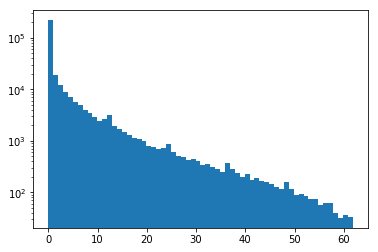

In [133]:
plt.hist(site_counts_df.site_tenure_months, bins=62, log=True)
plt.show()

In [134]:
np.sum(site_counts_df.journal_count >= 30) / len(site_counts_df), np.quantile(site_counts_df.journal_count, 0.999)

(0.0320968059413303, 90.93800000002375)

In [130]:
site_counts_df[site_counts_df.journal_count > 100]

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,has_received_interactions,has_received_amps,has_received_comments,site_tenure_months,interactions_count_log,journal_count_log
1974,857067,154,315,116,34883046000,False,True,431,True,True,True,13.457965,2.634477,2.187521
2444,857941,133,1728,481,5368644000,False,True,2209,True,True,True,2.071236,3.344196,2.123852
4434,861760,421,2,1,15268920000,False,True,3,True,True,True,5.890787,0.477121,2.624282
6700,866033,114,141,89,4315475000,False,True,230,True,True,True,1.664921,2.361728,2.056905
7817,868138,141,308,209,19010915000,False,True,517,True,True,True,7.334458,2.713491,2.149219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313235,1326359,201,0,0,961332000,True,False,0,False,False,False,0.370884,-1.000000,2.303196
313681,1326937,146,0,0,851921000,True,False,0,False,False,False,0.328673,-1.000000,2.164353
314634,1328120,113,0,0,695830000,True,False,0,False,False,False,0.268453,-1.000000,2.053078
314637,1328125,143,0,0,696193000,True,False,0,False,False,False,0.268593,-1.000000,2.155336


In [117]:
mdf.head()

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,has_received_interactions,has_received_amps,has_received_comments,site_tenure_months,interactions_count_log,journal_count_log
0,136505,1,0,0,0,False,True,0,False,False,False,0.000000,-1.00000,0.000000
1,140029,2,1,1,63802328000,False,True,2,True,True,True,24.615096,0.30103,0.301030
2,153666,1,0,0,0,False,True,0,False,False,False,0.000000,-1.00000,0.000000
3,167478,1,0,0,0,False,True,0,False,False,False,0.000000,-1.00000,0.000000
4,187527,11,0,0,6460732000,False,True,0,False,False,False,2.492566,-1.00000,1.041393


In [46]:
from lifelines import KaplanMeierFitter

In [47]:
T = mdf["site_tenure_months"]
E = ~mdf["is_right_censored"]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 320063 total observations, 49149 right-censored observations>

0.03904706790123457


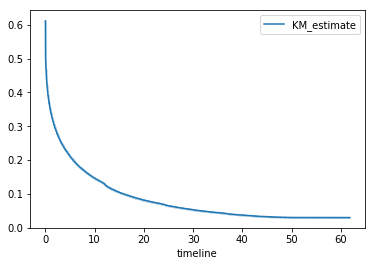

In [48]:
kmf.plot()
print(kmf.median_survival_time_)
plt.show()

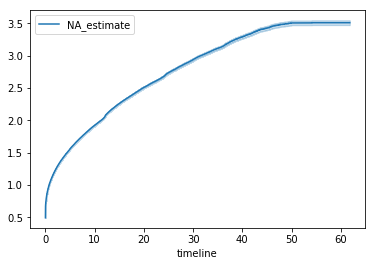

In [49]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter().fit(T, E)
naf.plot()
plt.show()

In [50]:
for right_censor_threshold_days in [0, 30, 90, 365, 365*2]:
    right_censor_threshold_ms = 1000 * 60 * 60 * 24 * right_censor_threshold_days
    right_censor_timestamp = end_timestamp - right_censor_threshold_ms
    print("Threshold (days):", right_censor_threshold_days)

    censored_journal_subset = journal_df[journal_df.created_at >= right_censor_timestamp]
    if len(censored_journal_subset) > 0:
        right_censored_site_ids = set(censored_journal_subset.site_id)
    else:
        right_censored_site_ids = set()

    is_right_censored = site_counts_df.site_id.map(lambda site_id: site_id in right_censored_site_ids)
    print("pct of sites considered right-censored:", np.sum(is_right_censored) / len(site_counts_df))

    kmf = KaplanMeierFitter()
    kmf.fit(site_counts_df.site_tenure_months, event_observed=~is_right_censored)
    median_survival_time = kmf.median_survival_time_
    print("KM median survival time:", median_survival_time)

Threshold (days): 0
pct of sites considered right-censored: 0.0
KM median survival time: 0.008611111111111111
Threshold (days): 30
pct of sites considered right-censored: 0.04336021345797546
KM median survival time: 0.0184891975308642
Threshold (days): 90
pct of sites considered right-censored: 0.07902194255505947
KM median survival time: 0.031073302469135804
Threshold (days): 365
pct of sites considered right-censored: 0.15356039279766795
KM median survival time: 0.03904706790123457
Threshold (days): 730
pct of sites considered right-censored: 0.23805000890449693
KM median survival time: 0.0670721450617284


In [51]:
# empirical observed tenure is well under a month
np.median(site_counts_df.site_tenure_months)

0.008611111111111111

In [52]:
# a full 41% of the data have only a single journal update (so tenure = 0)
np.sum(site_counts_df.site_tenure_months == 0) / len(site_counts_df)

0.41029734770966964

1.0

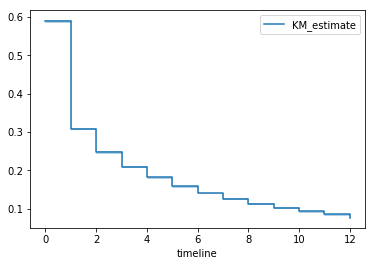

In [53]:
kmf = KaplanMeierFitter()
kmf.fit(site_counts_df.site_tenure_months, timeline=range(13), event_observed=np.ones(len(site_counts_df)))
kmf.plot()
kmf.median_survival_time_

In [54]:
from lifelines import CoxPHFitter

In [55]:
# assume no censoring
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'has_received_amps', 'has_received_comments', 'journal_count']], 
        duration_col='site_tenure_months',
        show_progress=True)
cph.print_summary()

Iteration 1: norm_delta = 0.73609, step_size = 0.9500, ll = -3737150.26401, newton_decrement = 104970.81571, seconds_since_start = 11.2
Iteration 2: norm_delta = 0.24438, step_size = 0.9500, ll = -3638232.04088, newton_decrement = 3480.09805, seconds_since_start = 22.7
Iteration 3: norm_delta = 0.07549, step_size = 0.9500, ll = -3634374.65321, newton_decrement = 268.22449, seconds_since_start = 34.1
Iteration 4: norm_delta = 0.00484, step_size = 1.0000, ll = -3634095.94914, newton_decrement = 1.01211, seconds_since_start = 45.3
Iteration 5: norm_delta = 0.00002, step_size = 1.0000, ll = -3634094.93452, newton_decrement = 0.00001, seconds_since_start = 56.5
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3634094.93451, newton_decrement = 0.00000, seconds_since_start = 67.8
Convergence success after 6 iterations.


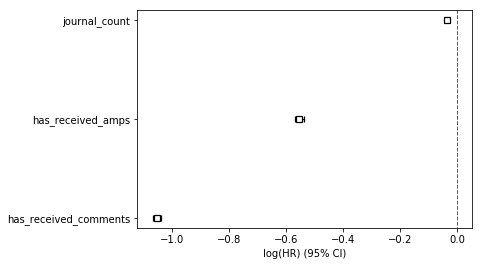

In [56]:
cph.plot()
plt.show()

In [263]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'has_received_amps', 'has_received_comments', 'journal_frequency_(2, 100]', 'amps_count_log', 'comment_count_log', 'journalfreq_comments_interaction', 'journalfreq_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 1.51736, step_size = 0.9500, ll = -3204498.25650, newton_decrement = 144537.83375, seconds_since_start = 9.6
Iteration 2: norm_delta = 0.58198, step_size = 0.9500, ll = -3081922.07272, newton_decrement = 6779.81698, seconds_since_start = 19.3
Iteration 3: norm_delta = 0.05097, step_size = 0.9500, ll = -3075824.90292, newton_decrement = 93.15402, seconds_since_start = 28.8
Iteration 4: norm_delta = 0.00138, step_size = 1.0000, ll = -3075730.25297, newton_decrement = 0.06144, seconds_since_start = 38.6
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3075730.19150, newton_decrement = 0.00000, seconds_since_start = 48.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 319801 total observations, 49081 right-censored observations>

In [265]:
cph.print_summary()

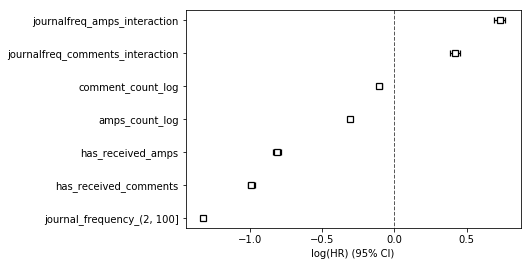

In [266]:
cph.plot()
plt.show()

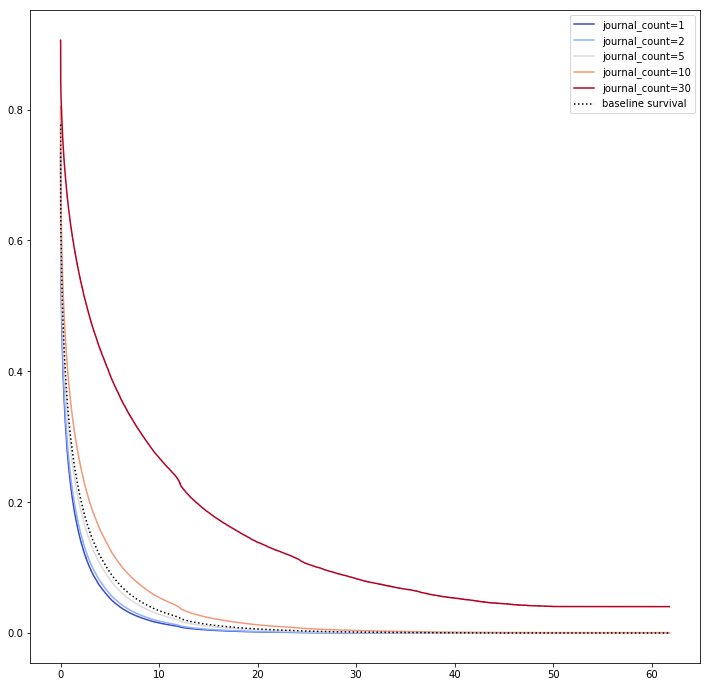

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('journal_count', [1, 2, 5, 10, 30], cmap='coolwarm', ax=ax)
plt.show()

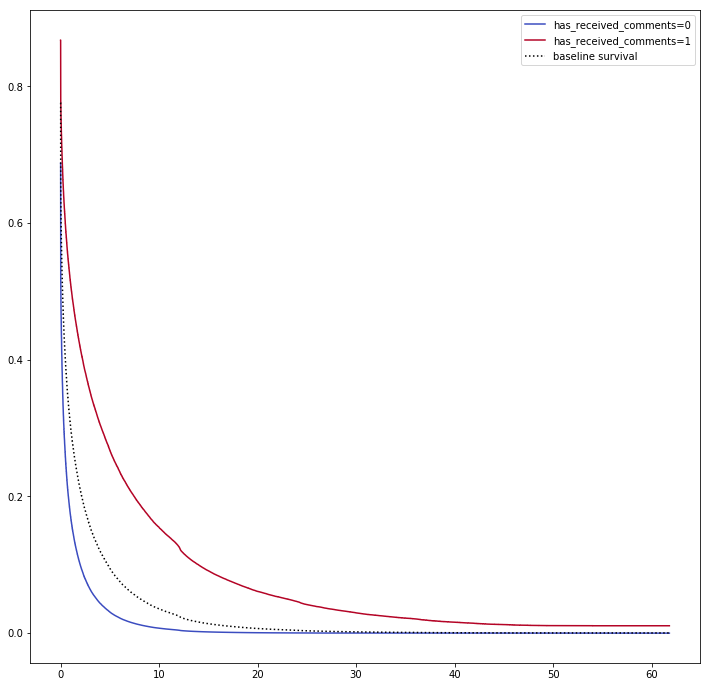

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('has_received_comments', [0, 1], cmap='coolwarm', ax=ax)
plt.show()

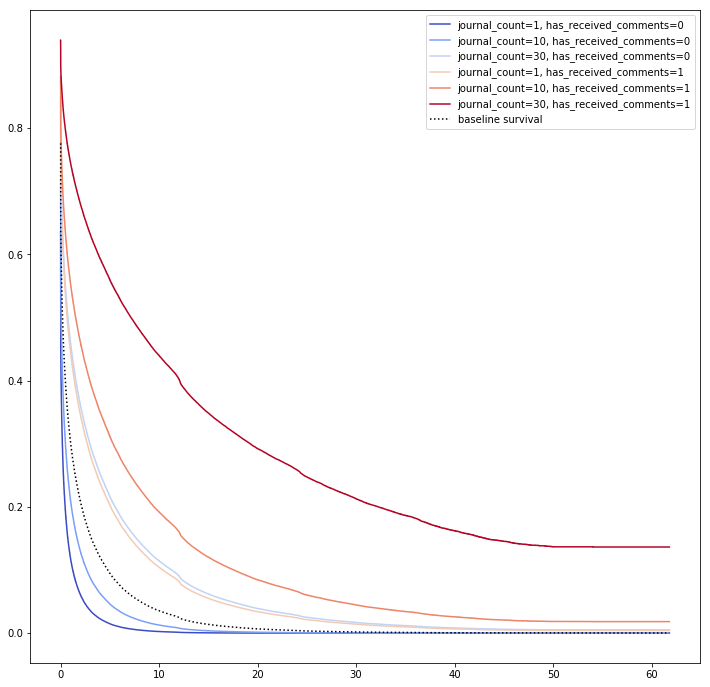

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'has_received_comments'], [(1, 0), (10, 0), (30, 0), (1, 1), (10, 1), (30, 1)], cmap='coolwarm', ax=ax)
plt.show()

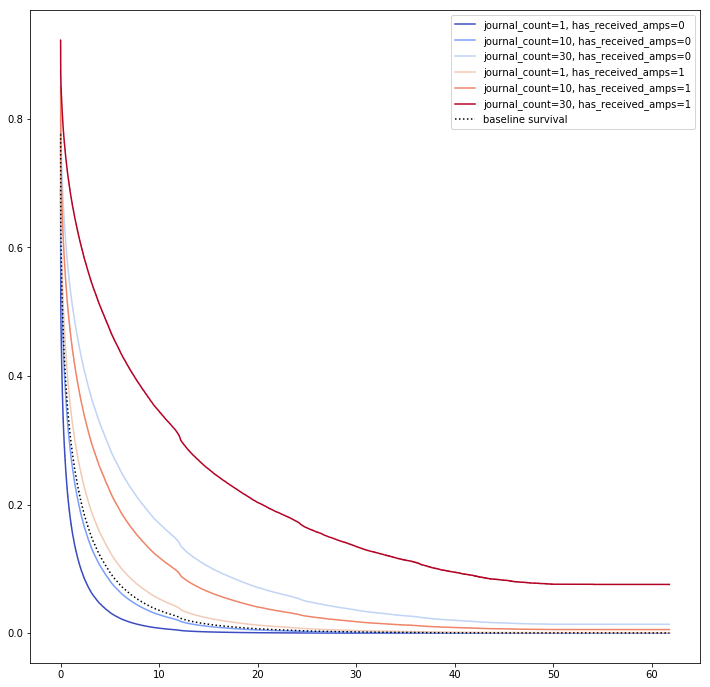

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'has_received_amps'], [(1, 0), (10, 0), (30, 0), (1, 1), (10, 1), (30, 1)], cmap='coolwarm', ax=ax)
plt.show()

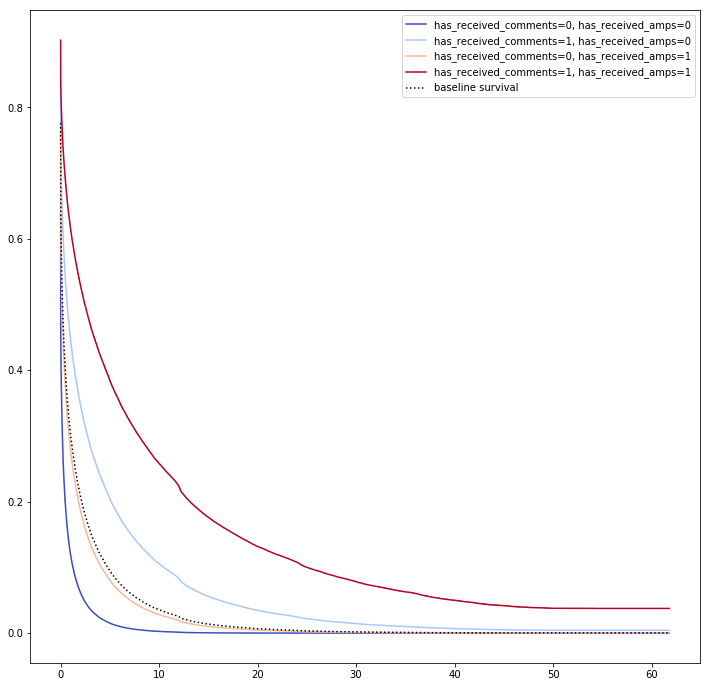

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['has_received_comments', 'has_received_amps'], [(0, 0), (1, 0), (0, 1), (1, 1)], cmap='coolwarm', ax=ax)
plt.show()

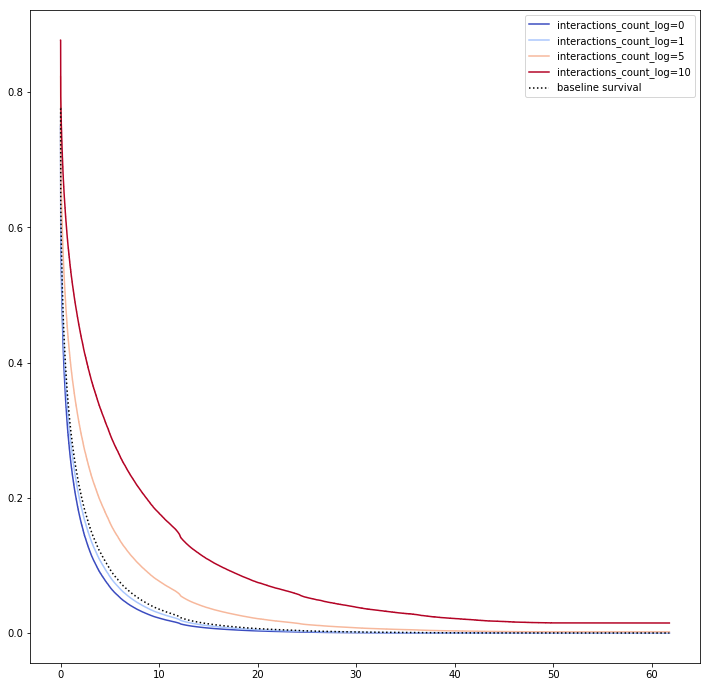

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('interactions_count_log', [0, 1, 5, 10], cmap='coolwarm', ax=ax)
plt.show()

In [67]:
mdf['amp_ratio'] = 0
mdf.loc[mdf.interactions_count > 0, 'amp_ratio'] = \
    (mdf.loc[mdf.interactions_count > 0, 'amps_count'] / mdf.loc[mdf.interactions_count > 0, 'interactions_count']) - 0.5

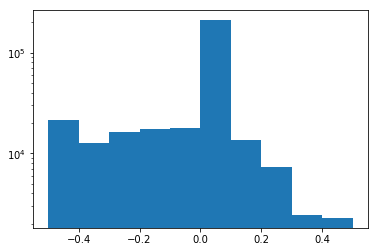

In [68]:
plt.hist(mdf.amp_ratio, log=True)
plt.show()

In [69]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_count', 'interactions_count', 'amp_ratio']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 0.34761, step_size = 0.9500, ll = -3207025.78207, newton_decrement = 24291.47015, seconds_since_start = 9.5
Iteration 2: norm_delta = 0.45507, step_size = 0.9500, ll = -3174924.79077, newton_decrement = 15953.67884, seconds_since_start = 19.1
Iteration 3: norm_delta = 0.24959, step_size = 0.9500, ll = -3156195.44969, newton_decrement = 3076.51995, seconds_since_start = 28.8
Iteration 4: norm_delta = 0.09605, step_size = 0.9310, ll = -3152830.17947, newton_decrement = 240.99492, seconds_since_start = 38.2
Iteration 5: norm_delta = 0.01132, step_size = 1.0000, ll = -3152576.78739, newton_decrement = 1.82384, seconds_since_start = 47.9
Iteration 6: norm_delta = 0.00011, step_size = 1.0000, ll = -3152574.95295, newton_decrement = 0.00014, seconds_since_start = 57.5
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3152574.95281, newton_decrement = 0.00000, seconds_since_start = 67.2
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 320063 total observations, 49149 right-censored observations>

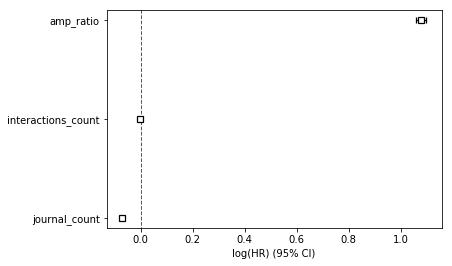

In [70]:
cph.print_summary()
cph.plot()
plt.show()

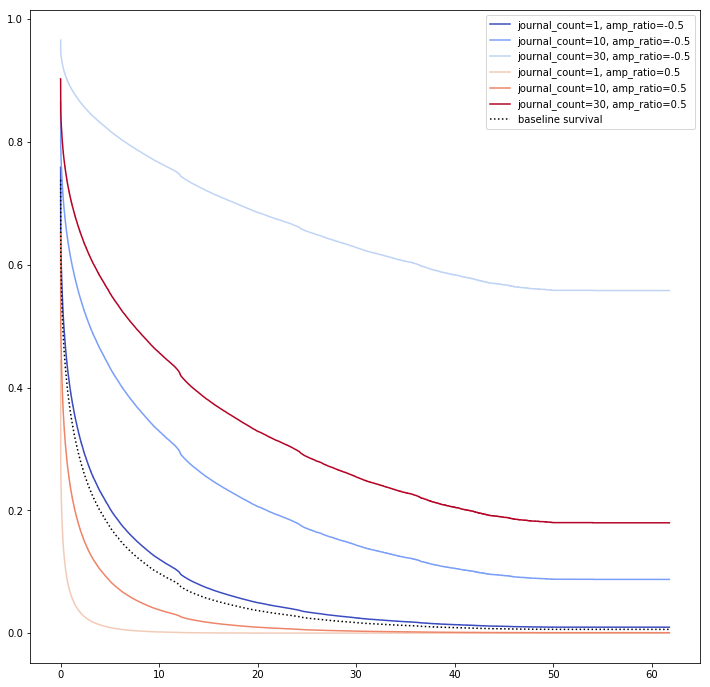

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'amp_ratio'], [(1, -0.5), (10, -0.5), (30, -0.5), (1, 0.5), (10, 0.5), (30, 0.5)], cmap='coolwarm', ax=ax)
plt.show()

In [145]:
np.quantile(mdf.journal_count, 0.25), np.quantile(mdf.journal_count, 0.5), np.quantile(mdf.journal_count, 0.75)

(1.0, 2.0, 8.0)

In [222]:
mdf['journal_frequency'] = pd.cut(mdf.journal_count, bins=[0, 2, 8, np.max(mdf.journal_count)])

In [165]:
mdf.journal_frequency

0           (0, 2]
1           (0, 2]
2           (0, 2]
3           (0, 2]
4         (8, 100]
            ...   
320058      (0, 2]
320059      (0, 2]
320060      (0, 2]
320061      (2, 8]
320062      (2, 8]
Name: journal_frequency, Length: 319801, dtype: category
Categories (3, interval[int64]): [(0, 2] < (2, 8] < (8, 100]]

In [152]:
# want to evaluate high vs low activity sites
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_frequency', 'interactions_count_log', 'has_received_comments', 'has_received_amps']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored', strata='journal_frequency',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 0.79803, step_size = 0.9500, ll = -2927357.77534, newton_decrement = 32625.91406, seconds_since_start = 13.8
Iteration 2: norm_delta = 0.09943, step_size = 0.9500, ll = -2896268.55461, newton_decrement = 55.51902, seconds_since_start = 27.7
Iteration 3: norm_delta = 0.00476, step_size = 0.9500, ll = -2896213.26530, newton_decrement = 0.12444, seconds_since_start = 41.7
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, ll = -2896213.14087, newton_decrement = 0.00000, seconds_since_start = 55.6
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 319801 total observations, 49081 right-censored observations>

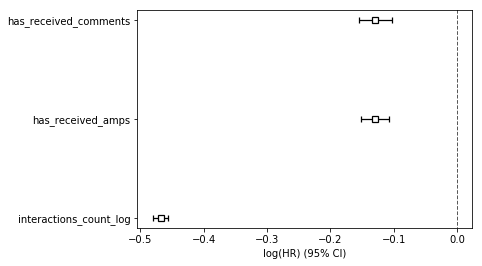

In [153]:
cph.print_summary()
cph.plot()
plt.show()

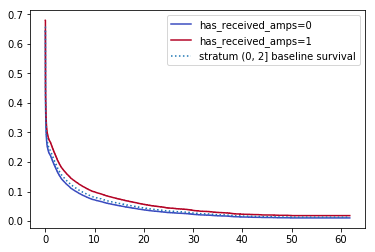

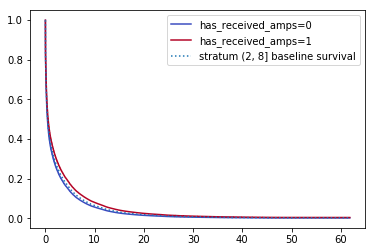

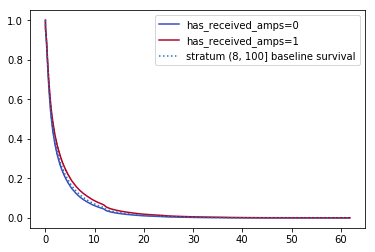

In [160]:
#fig, axes = plt.subplots(1, 3, figsize=(12,12))
cph.plot_covariate_groups('has_received_amps', [0, 1], cmap='coolwarm')
plt.show()

In [189]:
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[0],
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 12]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[0],
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 12])

(             0
 0.0   0.457560
 1.0   0.068964
 12.0  0.007185,              0
 0.0   0.719999
 1.0   0.325109
 12.0  0.125701)

In [190]:
0.325109 - 0.068964, 0.125701 - 0.007185

(0.25614499999999996, 0.11851600000000001)

In [188]:
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[2],
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 12]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[2],
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 12])

(             0
 0.0   0.999953
 1.0   0.351100
 12.0  0.003731,              0
 0.0   0.999980
 1.0   0.644178
 12.0  0.095447)

In [191]:
0.644178 - 0.351100, 0.095447 - 0.003731

(0.293078, 0.091716)

In [181]:
mdf.groupby('journal_frequency').size()

journal_frequency
(0, 2]      167935
(2, 8]       75164
(8, 100]     76702
dtype: int64

In [223]:
mdf = pd.concat([mdf, pd.get_dummies(mdf.journal_frequency, prefix='journal_frequency')], axis=1)

In [214]:
mdf.head(1)

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,has_received_interactions,has_received_amps,has_received_comments,site_tenure_months,interactions_count_log,journal_count_log,amps_count_log,comment_count_log,journal_frequency,"journal_frequency_(0, 2]","journal_frequency_(2, 8]","journal_frequency_(8, 100]"
0,136505,1,0,0,0,False,True,0,False,False,False,0.0,-1.0,0.0,0.0,0.0,"(0, 2]",1,0,0


In [215]:
# want to evaluate high vs low activity sites
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_frequency_(2, 8]', 'journal_frequency_(8, 100]', 'comment_count_log', 'amps_count_log', 'has_received_comments', 'has_received_amps']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 1.04786, step_size = 0.9500, ll = -3204498.25650, newton_decrement = 135033.12680, seconds_since_start = 9.4
Iteration 2: norm_delta = 0.24514, step_size = 0.9500, ll = -3081202.46058, newton_decrement = 2639.15622, seconds_since_start = 18.9
Iteration 3: norm_delta = 0.00666, step_size = 0.9500, ll = -3078680.03012, newton_decrement = 1.36625, seconds_since_start = 28.3
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, ll = -3078678.66276, newton_decrement = 0.00000, seconds_since_start = 37.6
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3078678.66275, newton_decrement = 0.00000, seconds_since_start = 46.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 319801 total observations, 49081 right-censored observations>

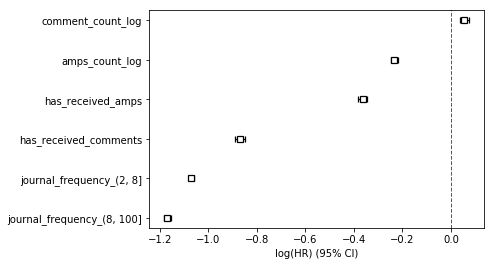

In [216]:
cph.print_summary()
cph.plot()
plt.show()

In [201]:
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 0,
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 6]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 0,
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 6])

(             0
 0.0   0.501543
 1.0   0.018166
 12.0  0.000004,              0
 0.0   0.779824
 1.0   0.235869
 12.0  0.011384)

In [203]:
0.235869 - 0.018166, 0.011384 - 0.000004

(0.21770299999999998, 0.01138)

In [202]:
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 1,
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 6]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 1,
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 6])

(            0
 0.0  0.801889
 1.0  0.277368
 6.0  0.061963,             0
 0.0  0.923516
 1.0  0.629923
 6.0  0.367033)

In [204]:
0.629923 - 0.277368, 0.367033 - 0.061963

(0.352555, 0.30507)